# Car of the Year: Predicting Car Demand with Linear Regression

## Project Goal

The goal of this project is to understand **which factors influence car demand** and to identify **which car models are likely to be the most desirable in 2025**.

Our dataset contains information about individual cars being sold, with features like:

- Manufacturer (brand)  
- Model  
- Engine size  
- Fuel type  
- Year of manufacture  
- Mileage (how much the car has been driven)  
- Resale price  

The dataset does **not** include actual sales volume (number of units sold).  

So instead of predicting "units sold", we treat the **resale price** of a car as a **representation of demand**:

> In used car markets, cars that are more desirable (reliable, popular, good brand, good condition) tend to **retain higher prices**, while less desirable cars lose value quickly.

## What we do in this notebook

1. Clean and explore the dataset.  
2. Build a **Linear Regression model** that predicts price based on the car’s features.  
3. Treat the predicted price from the model as a data-driven **demand score**.  
4. Use the model’s **coefficients** to understand which features affect demand the most.  
5. Use the **predicted demand score** to rank car models and suggest candidates for “Car of the Year”.  
6. Briefly explore the relationship between **reliability (mileage)** and **popularity (demand score)**.

This approach lets the **model learn the weights** for each feature.

## Step 2: Import libraries and load the dataset

In this step, we:
- Import the libraries needed for data handling, visualization, and machine learning.
- Load the CSV file into a pandas dataframe.
- Take a quick look at the first few rows to understand the structure of the dataset.



In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make plots look clean
plt.style.use("default")

# Load the dataset
df = pd.read_csv("car_sales_data.csv")

# Look at the first few rows
df.head()

,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price
0,Ford,Fiesta,1.0,Petrol,2002,127300,3074
1,Porsche,718 Cayman,4.0,Petrol,2016,57850,49704
2,Ford,Mondeo,1.6,Diesel,2014,39190,24072
3,Toyota,RAV4,1.8,Hybrid,1988,210814,1705
4,VW,Polo,1.0,Petrol,2006,127869,4101


## Step 3: Inspect and clean the data

Here we:
- Check the basic information about the dataset (column names, data types, missing values).
- Standardize column names (lowercase, underscores).
- Look for missing values in important columns and decide how to handle them.
- Make sure numeric columns are actually numeric.

This prepares the data for modeling.

In [ ]:
# Check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         50000 non-null  object 
 1   Model                50000 non-null  object 
 2   Engine size          50000 non-null  float64
 3   Fuel type            50000 non-null  object 
 4   Year of manufacture  50000 non-null  int64  
 5   Mileage              50000 non-null  int64  
 6   Price                50000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 2.7+ MB


In [ ]:
# Standardize column names: lowercase + replace spaces with underscores
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

df.head()

,manufacturer,model,engine_size,fuel_type,year_of_manufacture,mileage,price
0,Ford,Fiesta,1.0,Petrol,2002,127300,3074
1,Porsche,718 Cayman,4.0,Petrol,2016,57850,49704
2,Ford,Mondeo,1.6,Diesel,2014,39190,24072
3,Toyota,RAV4,1.8,Hybrid,1988,210814,1705
4,VW,Polo,1.0,Petrol,2006,127869,4101


In [ ]:
# Check for missing values
df.isnull().sum()

,0
manufacturer,0
model,0
engine_size,0
fuel_type,0
year_of_manufacture,0
mileage,0
price,0


In [ ]:
# Define critical columns for this project
critical_cols = ["manufacturer", "model", "engine_size", "fuel_type",
                 "year_of_manufacture", "mileage", "price"]

# Drop rows with missing values in critical columns
df = df.dropna(subset=critical_cols)

# Check again
df[critical_cols].isnull().sum()

,0
manufacturer,0
model,0
engine_size,0
fuel_type,0
year_of_manufacture,0
mileage,0
price,0


In [ ]:
# Ensure numeric columns are correct type
df["engine_size"] = pd.to_numeric(df["engine_size"], errors="coerce")
df["year_of_manufacture"] = pd.to_numeric(df["year_of_manufacture"], errors="coerce")
df["mileage"] = pd.to_numeric(df["mileage"], errors="coerce")
df["price"] = pd.to_numeric(df["price"], errors="coerce")

# Drop rows where conversion failed
df = df.dropna(subset=["engine_size", "year_of_manufacture", "mileage", "price"])

## Step 4: Exploratory Data Analysis (EDA)

Before building the model, we explore the data to understand patterns:

- Distribution of car prices (our **demand signal**).
- Relationship between mileage and price.
- Top manufacturers in the dataset.

These plots are useful both for understanding and for the final presentation.

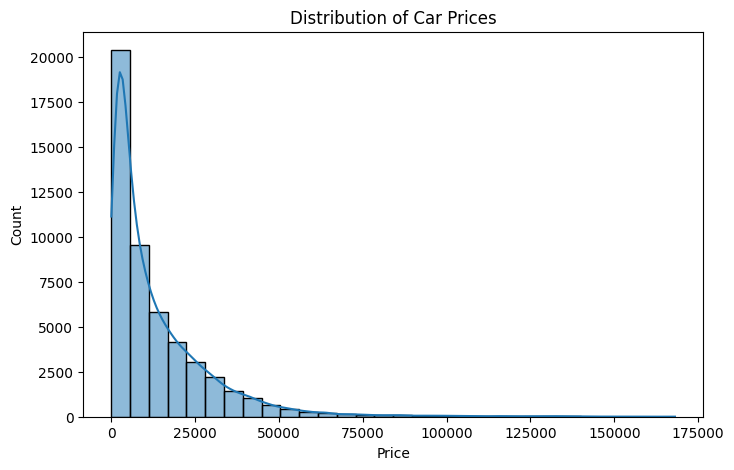

In [ ]:
#Price Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["price"], bins=30, kde=True)
plt.title("Distribution of Car Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

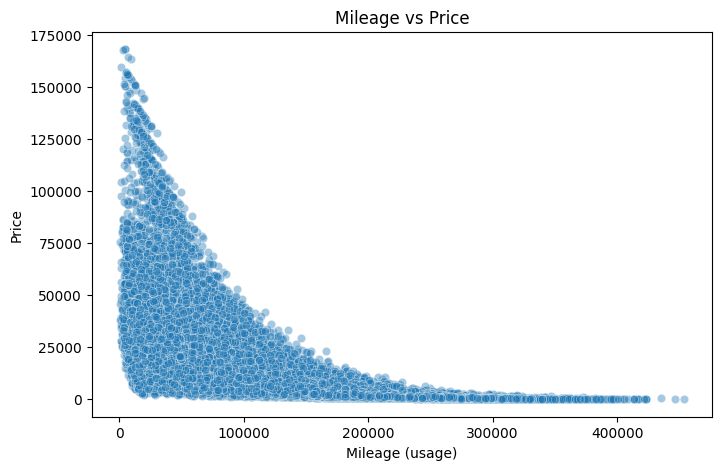

In [ ]:
#Mileage vs Price
plt.figure(figsize=(8, 5))
sns.scatterplot(x="mileage", y="price", data=df, alpha=0.4)
plt.title("Mileage vs Price")
plt.xlabel("Mileage (usage)")
plt.ylabel("Price")
plt.show()

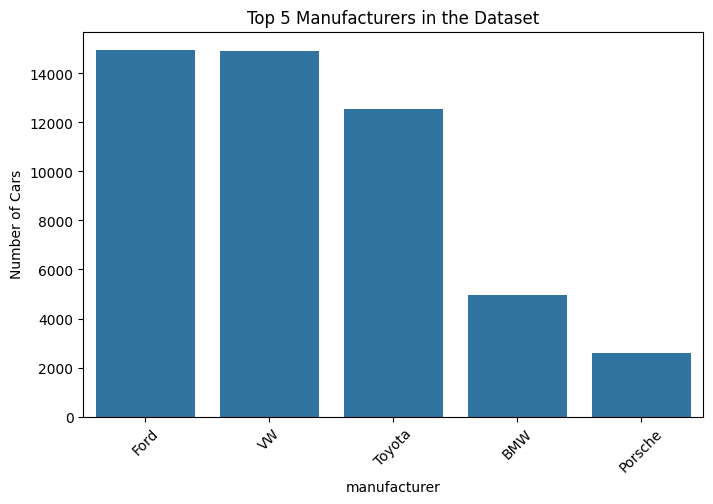

In [ ]:
#Top manufacturers by count
top_manufacturers = df["manufacturer"].value_counts().head(5)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_manufacturers.index, y=top_manufacturers.values)
plt.title("Top 5 Manufacturers in the Dataset")
plt.ylabel("Number of Cars")
plt.xticks(rotation=45)
plt.show()

## Step 5: Feature engineering

We now prepare our features for the regression model.

- Our target variable (y) will be **price**, which we treat as a **demand signal**.
- Our input features (X) will include:
  - engine_size
  - year_of_manufacture
  - mileage
  - manufacturer (one-hot encoding for algorithm to understand)
  - fuel_type (one-hot encoded)

We also:
- Create a car_id (manufacturer + model) to help us rank car models later based on predicted demand.
- Convert categorical variables into numeric variables using one-hot encoding.

In [ ]:
# Create a car id
df["car_id"] = df["manufacturer"] + " " + df["model"]

# Numeric features
numeric_features = ["engine_size", "year_of_manufacture", "mileage"]

# Categorical features
categorical_features = ["manufacturer", "fuel_type"]

# One-hot encode categorical features
df_encoded = pd.get_dummies(df[numeric_features + categorical_features], drop_first=True)

df_encoded.head()

,engine_size,year_of_manufacture,mileage,manufacturer_Ford,manufacturer_Porsche,manufacturer_Toyota,manufacturer_VW,fuel_type_Hybrid,fuel_type_Petrol
0,1.0,2002,127300,True,False,False,False,False,True
1,4.0,2016,57850,False,True,False,False,False,True
2,1.6,2014,39190,True,False,False,False,False,False
3,1.8,1988,210814,False,False,True,False,True,False
4,1.0,2006,127869,False,False,False,True,False,True


## Step 6: Define features (X) and target (y)

- **Target y**: price, treated as a demand signal.
- **Features X**: the encoded numeric matrix containing:
  - engine size
  - year of manufacture
  - mileage
  - manufacturer (one-hot encoded)
  - fuel type (one-hot encoded)

We then split the data into training and testing sets (80% / 20%) to evaluate how well the model generalizes.

In [ ]:
# Target variable y (demand signal)
y = df["price"]

# Features X
X = df_encoded

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((40000, 9), (10000, 9))

## Step 7: Train the Linear Regression model

We now:
- Initialize a LinearRegression model from scikit-learn.
- Fit it on the training data (X_train, y_train).

The model learns how each feature contributes to the car’s price (demand score).

In [ ]:
# Initialize model
lin_reg = LinearRegression()

# Train the model
lin_reg.fit(X_train, y_train)

LinearRegression()

## Step 8: Evaluate the model

We evaluate the model using standard regression metrics:

- **Mean Absolute Error (MAE):** average absolute difference between predicted and actual prices.
- **Mean Squared Error (MSE):** average squared difference (penalizes larger errors).
- **Root Mean Squared Error (RMSE):** square root of MSE, in the same units as price.
- **R² score:** proportion of variance in price explained by the model.

These help us understand how well the model fits the data.

In [ ]:
# Predict on the test data
y_pred = lin_reg.predict(X_test)

# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"MAE  (Mean Absolute Error): {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"R²   (R-squared): {r2:.3f}")

Model Evaluation Metrics:
MAE  (Mean Absolute Error): 5943.18
RMSE (Root Mean Squared Error): 9222.34
R²   (R-squared): 0.687


## Step 9: Analyze feature importance

Linear Regression gives us a **coefficient** for each feature.

- A **positive coefficient** means that as that feature increases, the predicted price (demand score) tends to **increase**.
- A **negative coefficient** means that as that feature increases, the predicted price tends to **decrease**.

Here we:
- Extract the model coefficients.
- Match them with their feature names.
- Sort them by absolute value to see which features have the biggest impact on demand.

In [ ]:
# Feature names and coefficients
feature_names = X.columns
coefficients = lin_reg.coef_

feature_importance = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
})

feature_importance["abs_coef"] = feature_importance["coefficient"].abs()
feature_importance_sorted = feature_importance.sort_values(by="abs_coef", ascending=False)

feature_importance_sorted.head(15)

,feature,coefficient,abs_coef
0,engine_size,8178.987202,8178.987202
4,manufacturer_Porsche,5262.349085,5262.349085
7,fuel_type_Hybrid,1978.228559,1978.228559
6,manufacturer_VW,-1885.521261,1885.521261
3,manufacturer_Ford,-1050.890353,1050.890353
1,year_of_manufacture,987.229655,987.229655
8,fuel_type_Petrol,-931.736545,931.736545
5,manufacturer_Toyota,40.052301,40.052301
2,mileage,-0.037684,0.037684


## Step 10: Predict demand score and rank car models

Now we use the trained model to:

1. Predict the **demand score** for each car in the dataset.
2. Treat the **predicted price** as a data-driven **demand score** (because it is based on all features, not just raw price).
3. Aggregate predictions by car_id (manufacturer + model).
4. Compute the **predicted demand score per model**.
5. Rank car models from highest to lowest average predicted demand.

The top-ranked models are our candidates for "Car of the Year".

In [ ]:
# Predict demand score for all cars
df["predicted_demand_score"] = lin_reg.predict(X)

# Average predicted demand per car model
model_demand = df.groupby("car_id")["predicted_demand_score"].mean().sort_values(ascending=False)

# Top 10 models by predicted demand
top_10_models = model_demand.head(10)
top_10_models

,predicted_demand_score
car_id,
BMW M5,35315.742539
Porsche Cayenne,32042.197294
Porsche 911,27646.255370
Porsche 718 Cayman,27351.644532
BMW X3,19722.230201
Toyota RAV4,18572.086522
BMW Z4,18446.884649
Toyota Prius,13541.815117
Ford Mondeo,13037.888868


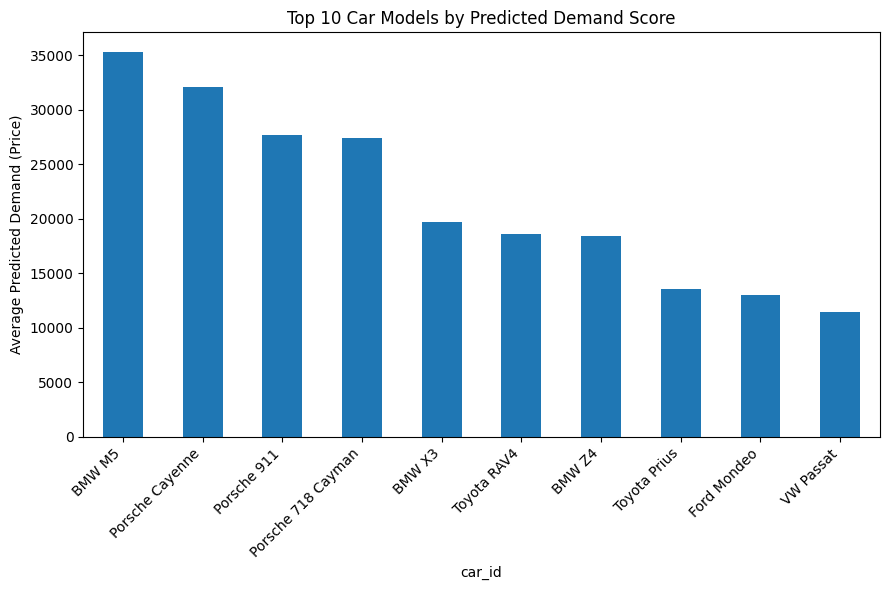

In [ ]:
plt.figure(figsize=(9, 6))
top_10_models.plot(kind="bar")
plt.title("Top 10 Car Models by Predicted Demand Score")
plt.ylabel("Average Predicted Demand (Price)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Step 11: Reliability vs popularity

The relationship between **reliability** and **popularity**.

In this dataset:
- We use **mileage** as a rough indicator for reliability (cars that are driven less are usually in better condition and seen as more reliable).
- We use our **predicted demand score** as an indicator for popularity.

We:
- Compute the correlation between mileage and predicted demand.
- Visualize the relationship.

In [ ]:
corr = df["mileage"].corr(df["predicted_demand_score"])
print(f"Correlation between mileage (usage) and predicted demand score: {corr:.3f}")

Correlation between mileage (usage) and predicted demand score: -0.760


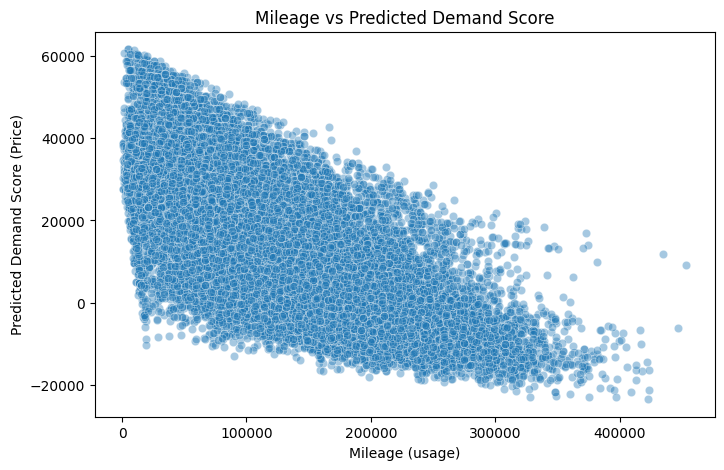

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x="mileage", y="predicted_demand_score", data=df, alpha=0.4)
plt.title("Mileage vs Predicted Demand Score")
plt.xlabel("Mileage (usage)")
plt.ylabel("Predicted Demand Score (Price)")
plt.show()